### final samples plot

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 

torch.manual_seed(990109)
np.random.seed(990109)

# Load digits data
digits = load_digits()
X = digits.images
y = digits.target

# Add Gaussian noise with variance 0.01
noise = scs.norm.rvs(0, 0.1, X.shape)
X_noisy = (X + noise)
X_noisy = (X_noisy - X_noisy.min()) / (X_noisy.max() - X_noisy.min()) # Normalize to [0, 1]

# Flatten the images for ECDF transformation
X_noisy_flat = X_noisy.reshape(-1, 64)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in range(64):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 8, 8)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)

# Convert to PyTorch tensors
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=8)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 8, 8)

    output:
        original_example: np.array - the original example, of shape (8, 8)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(8, 8) * 16
    
    return original_example


'''# Define the classifier for digits data (8x8 images)
class Classifier_Digits(nn.Module):
    def __init__(self, in_shape=(1, 8, 8)):
        super(Classifier_Digits, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 1)  # Adjusted for 8x8 input images
        )

    def forward(self, x):
        return self.model(x).exp()'''

# Define the classifier for digits data (8x8 images)
class Classifier_Digits(nn.Module):
    def __init__(self, in_shape=(1, 8, 8), normalising_cst=True, c=1.0):
        super(Classifier_Digits, self).__init__()
        self.normalising_cst = normalising_cst
        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 1)  # Adjusted for 8x8 input images
        )

    def forward(self, x):
        logits = self.model(x).exp()
        if self.normalising_cst:
            logits = logits * self.c
        return logits
# Define model
model = Classifier_Digits()

# Print model summary
summary(model, (1, 8, 8))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]             640
         LeakyReLU-2             [-1, 64, 4, 4]               0
            Conv2d-3             [-1, 64, 2, 2]          36,928
         LeakyReLU-4             [-1, 64, 2, 2]               0
           Flatten-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
Total params: 37,825
Trainable params: 37,825
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.14
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


In [2]:
# load samples vine
samples_vine = np.load(f'samples_vine0_scott.npy')
samples_vine = scs.norm.ppf(samples_vine)
# load samples IGC
samples_igc = np.load(f'samples_igc0.npy')
samples_igc = scs.norm.ppf(samples_igc)
# load samples ratio
samples_ratio = np.load(f'GGNNet_HM100burnin_N01_10_0_samples_digits.npy')
# load samples Gauss
samples_gauss = np.load(f'samples_gaussian0.npy')

C:\Users\david\AppData\Local\Temp\ipykernel_22352\3366373970.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[i, j].imshow(reverse_transform(torch.tensor(X_test[j % 5 * 5 + i + 100])).reshape(8,8), cmap='viridis')


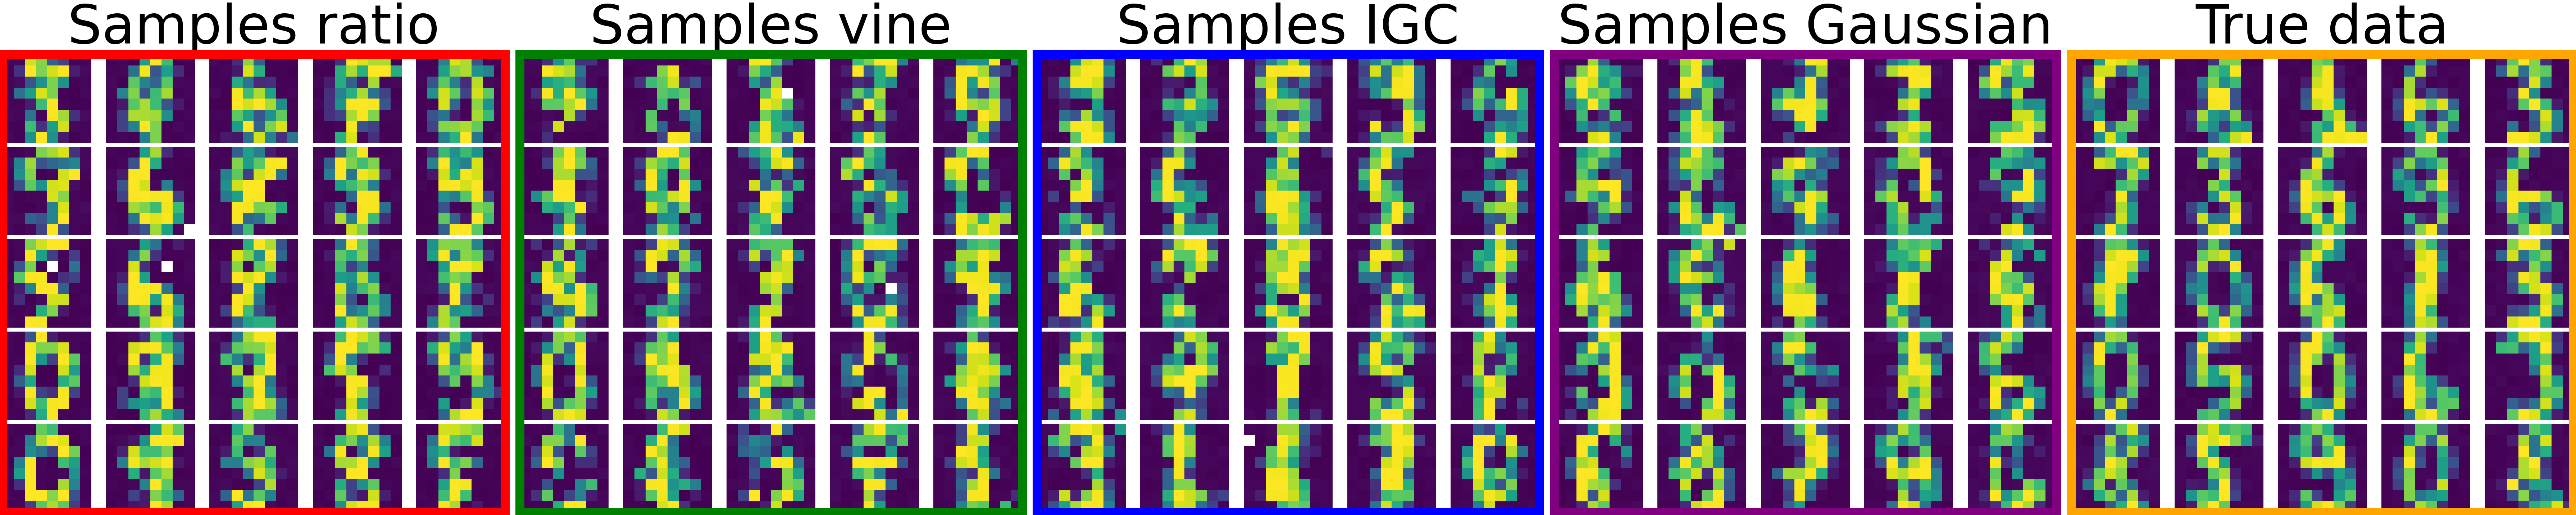

In [3]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Create the subplot grid
fig, axes = plt.subplots(5, 25, figsize=(100, 20))

# Create a function to draw a rectangle around groups of subplots
def draw_subplot_box(fig, start_col, end_col, color):
    # Calculate the bounding box of the group of subplots
    pos0 = axes[0, start_col].get_position()
    pos1 = axes[-1, end_col].get_position()

    # Create a rectangle spanning from top-left to bottom-right of the group
    rect = Rectangle((pos0.x0, pos1.y0), pos1.x1 - pos0.x0, pos0.y1 - pos1.y0,
                     linewidth=25, edgecolor=color, facecolor='none')
    fig.add_artist(rect)

# Create the plots and add an outline for each group of 5x5 plots
for i in range(5):
    for j in range(25):
        if j < 5:  # ratio copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_ratio[j % 5 * 5 + i])).reshape(8,8), cmap='viridis')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples ratio', fontsize=150)

        if 4 < j < 10:  # vine copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_vine[j % 5 * 5 + i])).reshape(8,8), cmap='viridis')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples vine', fontsize=150)

        if 9 < j < 15:  # igc copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_igc[j % 5 * 5 + i])).reshape(8,8), cmap='viridis')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples IGC', fontsize=150)

        if 14 < j < 20:  # Gaussian copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_gauss[j % 5 * 5 + i])).reshape(8,8), cmap='viridis')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples Gaussian', fontsize=150)

        if j > 19:  # true data
            axes[i, j].imshow(reverse_transform(torch.tensor(X_test[j % 5 * 5 + i + 100])).reshape(8,8), cmap='viridis')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'True data', fontsize=150)

plt.tight_layout()
# Draw rectangles around the 5x5 blocks of subplots
draw_subplot_box(fig, start_col=0, end_col=4, color='red')       # Ratio Copula
draw_subplot_box(fig, start_col=5, end_col=9, color='green')     # Vine Copula
draw_subplot_box(fig, start_col=10, end_col=14, color='blue')    # IGC Copula
draw_subplot_box(fig, start_col=15, end_col=19, color='purple')  # Gaussian Copula
draw_subplot_box(fig, start_col=20, end_col=24, color='orange')  # True Data
plt.savefig('digits_samples.pdf', bbox_inches='tight', dpi=50)
plt.show()
